# Learned rules

In this notebook, we will evaluate what simple rules a model has learned.

In [1]:
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms

from NegativeClassOptimization import ml
from NegativeClassOptimization import utils
from NegativeClassOptimization import preprocessing

/home/eugen/miniconda3/envs/nco/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/eugen/miniconda3/envs/nco/lib/python3.8/site-packages/torchvision/io/image.py:11: UserWarning: Failed to load image Python extension: /home/eugen/miniconda3/envs/nco/lib/python3.8/site-packages/torchvision/image.so: undefined symbol: _ZN5torch3jit17parseSchemaOrNameERKNSt7__cxx1112basic_stringIcSt11char_traitsIcESaIcEEE
  warn(f"Failed to load image Python extension: {e}")


In [5]:
df = utils.load_global_dataframe()

ag_pos = "3VRL"
ag_neg = "1ADQ"
df = df.loc[df["Antigen"].isin([ag_pos, ag_neg])].copy()
df = df.drop_duplicates(["Slide"])

N = 20000
df = df.sample(n=N, random_state=42)
df = df.sample(frac=1, random_state=42)

df_train = df.iloc[:int(N*0.8)]
df_test = df.iloc[int(N*0.8):]

In [6]:
train_data, test_data, train_loader, test_loader = preprocessing.preprocess_data_for_pytorch_binary(
    df_train_val=df_train,
    df_test_closed=df_test,
    ag_pos=[ag_pos],
    batch_size=32,
    scale_onehot=False,
)

/data/sources/eugen/negative-class-optimization/src/NegativeClassOptimization/NegativeClassOptimization/preprocessing.py:154: UserWarning: Not scaling onehot.
  warnings.warn("Not scaling onehot.")


In [7]:
model = ml.SN10()
model = model.to("cpu")

learning_rate = 0.01
epochs = 15
loss_fn = nn.BCELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    ml.train_loop(train_loader, model, loss_fn, optimizer)
    ml.test_loop(test_loader, model, loss_fn)

Epoch 1
-------------------------------
loss: 0.687983  [    0/16000]
loss: 0.687667  [ 3200/16000]
loss: 0.686262  [ 6400/16000]
loss: 0.664169  [ 9600/16000]
loss: 0.650876  [12800/16000]
Test Error: 
 Acc: 75.5 Avg loss: 0.640426 

Epoch 2
-------------------------------
loss: 0.641077  [    0/16000]
loss: 0.638007  [ 3200/16000]
loss: 0.556639  [ 6400/16000]
loss: 0.563854  [ 9600/16000]
loss: 0.585692  [12800/16000]
Test Error: 
 Acc: 79.2 Avg loss: 0.527314 

Epoch 3
-------------------------------
loss: 0.526680  [    0/16000]
loss: 0.503732  [ 3200/16000]
loss: 0.548404  [ 6400/16000]
loss: 0.387873  [ 9600/16000]
loss: 0.505673  [12800/16000]
Test Error: 
 Acc: 81.5 Avg loss: 0.449485 

Epoch 4
-------------------------------
loss: 0.537685  [    0/16000]
loss: 0.425131  [ 3200/16000]
loss: 0.486994  [ 6400/16000]
loss: 0.366617  [ 9600/16000]
loss: 0.541093  [12800/16000]
Test Error: 
 Acc: 82.5 Avg loss: 0.412517 

Epoch 5
-------------------------------
loss: 0.418812  [   

## Mine simple rules

In [33]:
slides = df["Slide"].unique().tolist()

# 1 amino acid
motifs_1 = set([])
for slide in slides:
    for i, aa in enumerate(slide):
        motif = "."*i + aa + "."*(11-i-1)
        motifs_1.add(motif)
print(f"# 1-motifs: {len(motifs_1)}")

# 2 amino acids
motifs_2 = set([])
for slide in slides:
    for i, aa_i in enumerate(slide):
        for x, aa_j in enumerate(slide[i+1:]):
            j = x+i+1
            motif = "."*(i) + aa_i + "."*x + aa_j + "."*(11-j-1)
            motifs_2.add(motif)
print(f"# 2-motifs: {len(motifs_2)} | max = {45*20*20}")

# 3 amino acids
# TODO

# 1-motifs: 219
# 2-motifs: 17256 | max = 18000


In [30]:
# list(filter(lambda x: x[0] != ".", motifs_1))
# list(filter(lambda x: x[-1] != ".", motifs_1))
# list(filter(lambda x: x[0] != ".", motifs_2))
# list(filter(lambda x: x[-1] != ".", motifs_2))

In [52]:
df_train_ag_p = df_train.loc[df_train["Antigen"] == ag_pos]
df_train_ag_n = df_train.ldef count_motifs(motifs, df_train_ag_p, df_train_ag_n):
oc[df_train["Antigen"] == ag_neg]

N = df_train.shape[0]
N_ag_p = df_train_ag_p.shape[0]
N_ag_n = df_train_ag_n.shape[0]

def count_motifs(motifs, df_train_ag_p, df_train_ag_n):
    records = []
    for motif in motifs:
        M = df_train["Slide"].str.contains(pat=motif).sum()
        M_ag_p = df_train_ag_p["Slide"].str.contains(pat=motif).sum()
        M_ag_n = df_train_ag_n["Slide"].str.contains(pat=motif).sum()
        records.append({
        "motif": motif,
        "M": M,
        "M_ag_p": M_ag_p,
        "M_ag_n": M_ag_n,
    })        
    return pd.DataFrame.from_records(records)

df_1 = count_motifs(motifs_1, df_train_ag_p, df_train_ag_n)
df_1 = df_1.sort_values(by="M", ascending=False)
df_1.head()

,motif,M,M_ag_p,M_ag_n
55,.........Y.,7213,4634,2579
147,..........W,7128,4126,3002
40,.......F...,5916,3453,2463
163,C..........,5855,4505,1350
174,........D..,5490,2962,2528


In [50]:
df_1["acc_int"] = df_1[["M_ag_p", "M_ag_n"]].apply(max, axis=1) / df_1["M"]
df_1["diff"] = abs(df_1["M_ag_p"] - df_1["M_ag_n"])

# df_1.sort_values(["acc_int", "M"], ascending=[False, False]).head(20)
df_1 = df_1.sort_values(by="diff", ascending=False)
df_1.head(20)

,motif,M,M_ag_p,M_ag_n,acc,diff,acc_int
163,C..........,5855,4505,1350,0.769428,3155,0.769428
79,.A.........,4767,3821,946,0.801552,2875,0.801552
96,..R........,4515,3454,1061,0.765006,2393,0.765006
209,.L.........,3356,540,2816,0.839094,2276,0.839094
216,......L....,4261,3216,1045,0.754752,2171,0.754752
55,.........Y.,7213,4634,2579,0.642451,2055,0.642451
67,.......L...,3778,2758,1020,0.730016,1738,0.730016
18,..L........,2400,354,2046,0.852500,1692,0.852500
200,.....L.....,5432,3356,2076,0.617820,1280,0.617820
199,.........D.,1283,76,1207,0.940764,1131,0.940764


<AxesSubplot:>

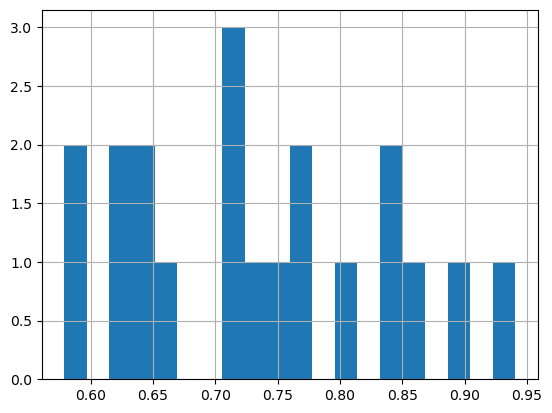

In [51]:
df_1["acc_int"].hist(bins=20)

Faster version

In [53]:
def record_motif(motifs, ag, motif):
    if motif not in motifs:
        motifs[motif] = {"M": 0, "M_p": 0, "M_n": 0}
    motifs[motif]["M"] += 1
    if ag == ag_pos:
        motifs[motif]["M_p"] += 1
    else:
        motifs[motif]["M_n"] += 1
    return motifs


motifs = {}
for i, row in df_train.iterrows():
    ag = row["Antigen"]
    slide = row["Slide"]
    
    # 1-motifs
    for i, aa in enumerate(slide):
        motif = "."*i + aa + "."*(11-i-1)    
        motifs = record_motif(motifs, ag, motif)
    
    # 2-motifs
    for i, aa_i in enumerate(slide):
        for x, aa_j in enumerate(slide[i+1:]):
            j = x+i+1
            motif = "."*(i) + aa_i + "."*x + aa_j + "."*(11-j-1)
            motifs = record_motif(motifs, ag, motif)

    # 3 amino acids
    # TODO

In [78]:
df_motifs = pd.DataFrame.from_dict(motifs, orient='index')
df_motifs = df_motifs.reset_index().rename(columns={"index": "motif"})
df_motifs["is_motif_1"] = df_motifs["motif"].str.count("\.") == 10
df_motifs["is_motif_2"] = df_motifs["motif"].str.count("\.") == 9

df_motifs["acc_int"] = df_motifs[["M_p", "M_n"]].apply(max, axis=1) / df_motifs["M"]
df_motifs["acc"] = ( df_motifs["acc_int"] * df_motifs["M"] + 0.5 * (N - df_motifs["M"]) ) / N

df_motifs["diff"] = abs(df_motifs["M_p"] - df_motifs["M_n"])

df_motifs = df_motifs.sort_values(by="acc", ascending=False)

df_motifs.head(30)

,motif,M,M_p,M_n,is_motif_1,is_motif_2,acc_int,acc,diff
188,C..........,5855,4505,1350,True,False,0.769428,0.598594,3155
189,.A.........,4767,3821,946,True,False,0.801552,0.589844,2875
196,CA.........,4519,3642,877,False,True,0.805931,0.586406,2765
197,C.R........,3807,3141,666,False,True,0.825059,0.577344,2475
190,..R........,4515,3454,1061,True,False,0.765006,0.574781,2393
1,.L.........,3356,540,2816,True,False,0.839094,0.571125,2276
206,.AR........,3362,2812,550,False,True,0.836407,0.570688,2262
811,......L....,4261,3216,1045,True,False,0.754752,0.567844,2171
366,C........Y.,2797,2452,345,False,True,0.876654,0.565844,2107
257,.........Y.,7213,4634,2579,True,False,0.642451,0.564219,2055


<AxesSubplot:xlabel='M', ylabel='acc_int'>

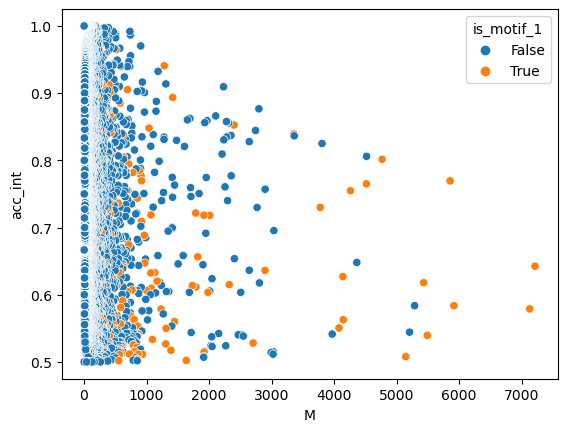

In [79]:
sns.scatterplot(data=df_motifs, x="M", y="acc_int", hue="is_motif_1")

Evaluate model on rule set

In [92]:
df_motifs_sel = df_motifs.loc[(df_motifs["M"] >= 500) & (df_motifs["acc_int"] >= 0.85)].copy()
print(df_motifs_sel.shape)
df_motifs_sel.head(20)

(51, 9)


,motif,M,M_p,M_n,is_motif_1,is_motif_2,acc_int,acc,diff
366,C........Y.,2797,2452,345,False,True,0.876654,0.565844,2107
375,.A.......Y.,2231,2029,202,False,True,0.909458,0.557094,1827
2,..L........,2400,354,2046,True,False,0.852500,0.552875,1692
823,.A....L....,2313,1979,334,False,True,0.855599,0.551406,1645
829,..R...L....,2283,1957,326,False,True,0.857205,0.550969,1631
850,......LL...,2278,1954,324,False,True,0.857770,0.550937,1630
458,..R......Y.,2106,1824,282,False,True,0.866097,0.548188,1542
452,.A........F,1966,1689,277,False,True,0.859105,0.544125,1412
459,..R.......F,1931,1653,278,False,True,0.856033,0.542969,1375
367,C.........W,1693,1460,233,False,True,0.862374,0.538344,1227


In [95]:
metrics_on_motifs = {}

for motif in df_motifs_sel["motif"]:
    df_train_m = df_train.loc[df_train["Slide"].str.contains(pat=motif)].copy()
    _, _, train_m_loader, _ = preprocessing.preprocess_data_for_pytorch_binary(
        df_train_val=df_train_m,
        df_test_closed=df_test,
        ag_pos=[ag_pos],
        batch_size=32,
        scale_onehot=False,
    )
    metrics = ml.test_loop(train_m_loader, model, loss_fn)
    metrics_on_motifs[motif] = metrics

/data/sources/eugen/negative-class-optimization/src/NegativeClassOptimization/NegativeClassOptimization/preprocessing.py:154: UserWarning: Not scaling onehot.
  warnings.warn("Not scaling onehot.")


Test Error: 
 Acc: 89.0 Avg loss: 0.320359 



/data/sources/eugen/negative-class-optimization/src/NegativeClassOptimization/NegativeClassOptimization/preprocessing.py:154: UserWarning: Not scaling onehot.
  warnings.warn("Not scaling onehot.")


Test Error: 
 Acc: 90.9 Avg loss: 0.285213 



/data/sources/eugen/negative-class-optimization/src/NegativeClassOptimization/NegativeClassOptimization/preprocessing.py:154: UserWarning: Not scaling onehot.
  warnings.warn("Not scaling onehot.")


Test Error: 
 Acc: 89.8 Avg loss: 0.268021 



/data/sources/eugen/negative-class-optimization/src/NegativeClassOptimization/NegativeClassOptimization/preprocessing.py:154: UserWarning: Not scaling onehot.
  warnings.warn("Not scaling onehot.")


Test Error: 
 Acc: 90.1 Avg loss: 0.294763 



/data/sources/eugen/negative-class-optimization/src/NegativeClassOptimization/NegativeClassOptimization/preprocessing.py:154: UserWarning: Not scaling onehot.
  warnings.warn("Not scaling onehot.")


Test Error: 
 Acc: 89.4 Avg loss: 0.307611 



/data/sources/eugen/negative-class-optimization/src/NegativeClassOptimization/NegativeClassOptimization/preprocessing.py:154: UserWarning: Not scaling onehot.
  warnings.warn("Not scaling onehot.")


Test Error: 
 Acc: 88.5 Avg loss: 0.323505 



/data/sources/eugen/negative-class-optimization/src/NegativeClassOptimization/NegativeClassOptimization/preprocessing.py:154: UserWarning: Not scaling onehot.
  warnings.warn("Not scaling onehot.")


Test Error: 
 Acc: 89.5 Avg loss: 0.316351 



/data/sources/eugen/negative-class-optimization/src/NegativeClassOptimization/NegativeClassOptimization/preprocessing.py:154: UserWarning: Not scaling onehot.
  warnings.warn("Not scaling onehot.")


Test Error: 
 Acc: 86.9 Avg loss: 0.329657 



/data/sources/eugen/negative-class-optimization/src/NegativeClassOptimization/NegativeClassOptimization/preprocessing.py:154: UserWarning: Not scaling onehot.
  warnings.warn("Not scaling onehot.")


Test Error: 
 Acc: 86.6 Avg loss: 0.341286 



/data/sources/eugen/negative-class-optimization/src/NegativeClassOptimization/NegativeClassOptimization/preprocessing.py:154: UserWarning: Not scaling onehot.
  warnings.warn("Not scaling onehot.")


Test Error: 
 Acc: 88.1 Avg loss: 0.328589 



/data/sources/eugen/negative-class-optimization/src/NegativeClassOptimization/NegativeClassOptimization/preprocessing.py:154: UserWarning: Not scaling onehot.
  warnings.warn("Not scaling onehot.")


Test Error: 
 Acc: 86.8 Avg loss: 0.357535 



/data/sources/eugen/negative-class-optimization/src/NegativeClassOptimization/NegativeClassOptimization/preprocessing.py:154: UserWarning: Not scaling onehot.
  warnings.warn("Not scaling onehot.")


Test Error: 
 Acc: 96.6 Avg loss: 0.111147 



/data/sources/eugen/negative-class-optimization/src/NegativeClassOptimization/NegativeClassOptimization/preprocessing.py:154: UserWarning: Not scaling onehot.
  warnings.warn("Not scaling onehot.")


Test Error: 
 Acc: 95.0 Avg loss: 0.142106 



/data/sources/eugen/negative-class-optimization/src/NegativeClassOptimization/NegativeClassOptimization/preprocessing.py:154: UserWarning: Not scaling onehot.
  warnings.warn("Not scaling onehot.")


Test Error: 
 Acc: 90.8 Avg loss: 0.278594 



/data/sources/eugen/negative-class-optimization/src/NegativeClassOptimization/NegativeClassOptimization/preprocessing.py:154: UserWarning: Not scaling onehot.
  warnings.warn("Not scaling onehot.")


Test Error: 
 Acc: 92.9 Avg loss: 0.210817 



/data/sources/eugen/negative-class-optimization/src/NegativeClassOptimization/NegativeClassOptimization/preprocessing.py:154: UserWarning: Not scaling onehot.
  warnings.warn("Not scaling onehot.")


Test Error: 
 Acc: 91.2 Avg loss: 0.247962 



/data/sources/eugen/negative-class-optimization/src/NegativeClassOptimization/NegativeClassOptimization/preprocessing.py:154: UserWarning: Not scaling onehot.
  warnings.warn("Not scaling onehot.")


Test Error: 
 Acc: 88.4 Avg loss: 0.326745 



/data/sources/eugen/negative-class-optimization/src/NegativeClassOptimization/NegativeClassOptimization/preprocessing.py:154: UserWarning: Not scaling onehot.
  warnings.warn("Not scaling onehot.")


Test Error: 
 Acc: 97.7 Avg loss: 0.083657 



/data/sources/eugen/negative-class-optimization/src/NegativeClassOptimization/NegativeClassOptimization/preprocessing.py:154: UserWarning: Not scaling onehot.
  warnings.warn("Not scaling onehot.")


Test Error: 
 Acc: 92.9 Avg loss: 0.225222 



/data/sources/eugen/negative-class-optimization/src/NegativeClassOptimization/NegativeClassOptimization/preprocessing.py:154: UserWarning: Not scaling onehot.
  warnings.warn("Not scaling onehot.")


Test Error: 
 Acc: 91.7 Avg loss: 0.239431 



/data/sources/eugen/negative-class-optimization/src/NegativeClassOptimization/NegativeClassOptimization/preprocessing.py:154: UserWarning: Not scaling onehot.
  warnings.warn("Not scaling onehot.")


Test Error: 
 Acc: 92.9 Avg loss: 0.195393 



/data/sources/eugen/negative-class-optimization/src/NegativeClassOptimization/NegativeClassOptimization/preprocessing.py:154: UserWarning: Not scaling onehot.
  warnings.warn("Not scaling onehot.")


Test Error: 
 Acc: 98.9 Avg loss: 0.063686 



/data/sources/eugen/negative-class-optimization/src/NegativeClassOptimization/NegativeClassOptimization/preprocessing.py:154: UserWarning: Not scaling onehot.
  warnings.warn("Not scaling onehot.")


Test Error: 
 Acc: 99.2 Avg loss: 0.056899 



/data/sources/eugen/negative-class-optimization/src/NegativeClassOptimization/NegativeClassOptimization/preprocessing.py:154: UserWarning: Not scaling onehot.
  warnings.warn("Not scaling onehot.")


Test Error: 
 Acc: 90.9 Avg loss: 0.257822 



/data/sources/eugen/negative-class-optimization/src/NegativeClassOptimization/NegativeClassOptimization/preprocessing.py:154: UserWarning: Not scaling onehot.
  warnings.warn("Not scaling onehot.")


Test Error: 
 Acc: 89.8 Avg loss: 0.294824 



/data/sources/eugen/negative-class-optimization/src/NegativeClassOptimization/NegativeClassOptimization/preprocessing.py:154: UserWarning: Not scaling onehot.
  warnings.warn("Not scaling onehot.")


Test Error: 
 Acc: 95.7 Avg loss: 0.151694 



/data/sources/eugen/negative-class-optimization/src/NegativeClassOptimization/NegativeClassOptimization/preprocessing.py:154: UserWarning: Not scaling onehot.
  warnings.warn("Not scaling onehot.")


Test Error: 
 Acc: 94.8 Avg loss: 0.171298 



/data/sources/eugen/negative-class-optimization/src/NegativeClassOptimization/NegativeClassOptimization/preprocessing.py:154: UserWarning: Not scaling onehot.
  warnings.warn("Not scaling onehot.")


Test Error: 
 Acc: 96.4 Avg loss: 0.111524 



/data/sources/eugen/negative-class-optimization/src/NegativeClassOptimization/NegativeClassOptimization/preprocessing.py:154: UserWarning: Not scaling onehot.
  warnings.warn("Not scaling onehot.")


Test Error: 
 Acc: 94.8 Avg loss: 0.165765 



/data/sources/eugen/negative-class-optimization/src/NegativeClassOptimization/NegativeClassOptimization/preprocessing.py:154: UserWarning: Not scaling onehot.
  warnings.warn("Not scaling onehot.")


Test Error: 
 Acc: 87.9 Avg loss: 0.294119 



/data/sources/eugen/negative-class-optimization/src/NegativeClassOptimization/NegativeClassOptimization/preprocessing.py:154: UserWarning: Not scaling onehot.
  warnings.warn("Not scaling onehot.")


Test Error: 
 Acc: 95.3 Avg loss: 0.136339 



/data/sources/eugen/negative-class-optimization/src/NegativeClassOptimization/NegativeClassOptimization/preprocessing.py:154: UserWarning: Not scaling onehot.
  warnings.warn("Not scaling onehot.")


Test Error: 
 Acc: 93.0 Avg loss: 0.221352 



/data/sources/eugen/negative-class-optimization/src/NegativeClassOptimization/NegativeClassOptimization/preprocessing.py:154: UserWarning: Not scaling onehot.
  warnings.warn("Not scaling onehot.")


Test Error: 
 Acc: 90.7 Avg loss: 0.250952 



/data/sources/eugen/negative-class-optimization/src/NegativeClassOptimization/NegativeClassOptimization/preprocessing.py:154: UserWarning: Not scaling onehot.
  warnings.warn("Not scaling onehot.")


Test Error: 
 Acc: 96.2 Avg loss: 0.142328 



/data/sources/eugen/negative-class-optimization/src/NegativeClassOptimization/NegativeClassOptimization/preprocessing.py:154: UserWarning: Not scaling onehot.
  warnings.warn("Not scaling onehot.")


Test Error: 
 Acc: 96.1 Avg loss: 0.132476 



/data/sources/eugen/negative-class-optimization/src/NegativeClassOptimization/NegativeClassOptimization/preprocessing.py:154: UserWarning: Not scaling onehot.
  warnings.warn("Not scaling onehot.")


Test Error: 
 Acc: 92.9 Avg loss: 0.203343 



/data/sources/eugen/negative-class-optimization/src/NegativeClassOptimization/NegativeClassOptimization/preprocessing.py:154: UserWarning: Not scaling onehot.
  warnings.warn("Not scaling onehot.")


Test Error: 
 Acc: 94.5 Avg loss: 0.171682 



/data/sources/eugen/negative-class-optimization/src/NegativeClassOptimization/NegativeClassOptimization/preprocessing.py:154: UserWarning: Not scaling onehot.
  warnings.warn("Not scaling onehot.")


Test Error: 
 Acc: 98.6 Avg loss: 0.037818 



/data/sources/eugen/negative-class-optimization/src/NegativeClassOptimization/NegativeClassOptimization/preprocessing.py:154: UserWarning: Not scaling onehot.
  warnings.warn("Not scaling onehot.")


Test Error: 
 Acc: 98.8 Avg loss: 0.074626 



/data/sources/eugen/negative-class-optimization/src/NegativeClassOptimization/NegativeClassOptimization/preprocessing.py:154: UserWarning: Not scaling onehot.
  warnings.warn("Not scaling onehot.")


Test Error: 
 Acc: 98.4 Avg loss: 0.082253 



/data/sources/eugen/negative-class-optimization/src/NegativeClassOptimization/NegativeClassOptimization/preprocessing.py:154: UserWarning: Not scaling onehot.
  warnings.warn("Not scaling onehot.")


Test Error: 
 Acc: 90.4 Avg loss: 0.252502 



/data/sources/eugen/negative-class-optimization/src/NegativeClassOptimization/NegativeClassOptimization/preprocessing.py:154: UserWarning: Not scaling onehot.
  warnings.warn("Not scaling onehot.")


Test Error: 
 Acc: 92.4 Avg loss: 0.202761 



/data/sources/eugen/negative-class-optimization/src/NegativeClassOptimization/NegativeClassOptimization/preprocessing.py:154: UserWarning: Not scaling onehot.
  warnings.warn("Not scaling onehot.")


Test Error: 
 Acc: 94.7 Avg loss: 0.137033 



/data/sources/eugen/negative-class-optimization/src/NegativeClassOptimization/NegativeClassOptimization/preprocessing.py:154: UserWarning: Not scaling onehot.
  warnings.warn("Not scaling onehot.")


Test Error: 
 Acc: 98.6 Avg loss: 0.077431 



/data/sources/eugen/negative-class-optimization/src/NegativeClassOptimization/NegativeClassOptimization/preprocessing.py:154: UserWarning: Not scaling onehot.
  warnings.warn("Not scaling onehot.")


Test Error: 
 Acc: 95.4 Avg loss: 0.157539 



/data/sources/eugen/negative-class-optimization/src/NegativeClassOptimization/NegativeClassOptimization/preprocessing.py:154: UserWarning: Not scaling onehot.
  warnings.warn("Not scaling onehot.")


Test Error: 
 Acc: 86.7 Avg loss: 0.270187 



/data/sources/eugen/negative-class-optimization/src/NegativeClassOptimization/NegativeClassOptimization/preprocessing.py:154: UserWarning: Not scaling onehot.
  warnings.warn("Not scaling onehot.")


Test Error: 
 Acc: 92.3 Avg loss: 0.175328 



/data/sources/eugen/negative-class-optimization/src/NegativeClassOptimization/NegativeClassOptimization/preprocessing.py:154: UserWarning: Not scaling onehot.
  warnings.warn("Not scaling onehot.")


Test Error: 
 Acc: 91.2 Avg loss: 0.224130 



/data/sources/eugen/negative-class-optimization/src/NegativeClassOptimization/NegativeClassOptimization/preprocessing.py:154: UserWarning: Not scaling onehot.
  warnings.warn("Not scaling onehot.")


Test Error: 
 Acc: 90.6 Avg loss: 0.241401 



/data/sources/eugen/negative-class-optimization/src/NegativeClassOptimization/NegativeClassOptimization/preprocessing.py:154: UserWarning: Not scaling onehot.
  warnings.warn("Not scaling onehot.")


Test Error: 
 Acc: 94.4 Avg loss: 0.197825 



/data/sources/eugen/negative-class-optimization/src/NegativeClassOptimization/NegativeClassOptimization/preprocessing.py:154: UserWarning: Not scaling onehot.
  warnings.warn("Not scaling onehot.")


Test Error: 
 Acc: 87.5 Avg loss: 0.339854 



In [120]:
for motif in metrics_on_motifs.keys():
    sn10_acc = metrics_on_motifs[motif]["acc_closed"]
    df_motifs_sel.loc[df_motifs_sel["motif"] == motif, "sn10_acc"] = sn10_acc

In [126]:
df_motifs_sel["acc_diff"] = df_motifs_sel["acc_int"] - df_motifs_sel["sn10_acc"]
df_motifs_sel.sort_values(by="acc_diff", ascending=False).head(20)

,motif,M,M_p,M_n,is_motif_1,is_motif_2,acc_int,acc,diff,sn10_acc,acc_diff
488,..........D,696,66,630,True,False,0.905172,0.517625,564,0.879310,0.025862
376,.A........W,1309,1196,113,False,True,0.913675,0.533844,1083,0.908327,0.005348
106,....L....D.,572,19,553,False,True,0.966783,0.516687,534,0.961538,0.005245
1027,.A......D..,851,768,83,False,True,0.902468,0.521406,685,0.897767,0.004700
21,.LL........,1184,80,1104,False,True,0.932432,0.532000,1024,0.929054,0.003378
88,.L........Y,505,6,499,False,True,0.988119,0.515406,493,0.986139,0.001980
34,..L....Y...,531,27,504,False,True,0.949153,0.514906,477,0.947269,0.001883
61,.......Y.D.,734,6,728,False,True,0.991826,0.522563,722,0.991826,0.000000
375,.A.......Y.,2231,2029,202,False,True,0.909458,0.557094,1827,0.909458,0.000000
2012,.A...W.....,744,711,33,False,True,0.955645,0.521188,678,0.956989,-0.001344


(0.85, 1.0)

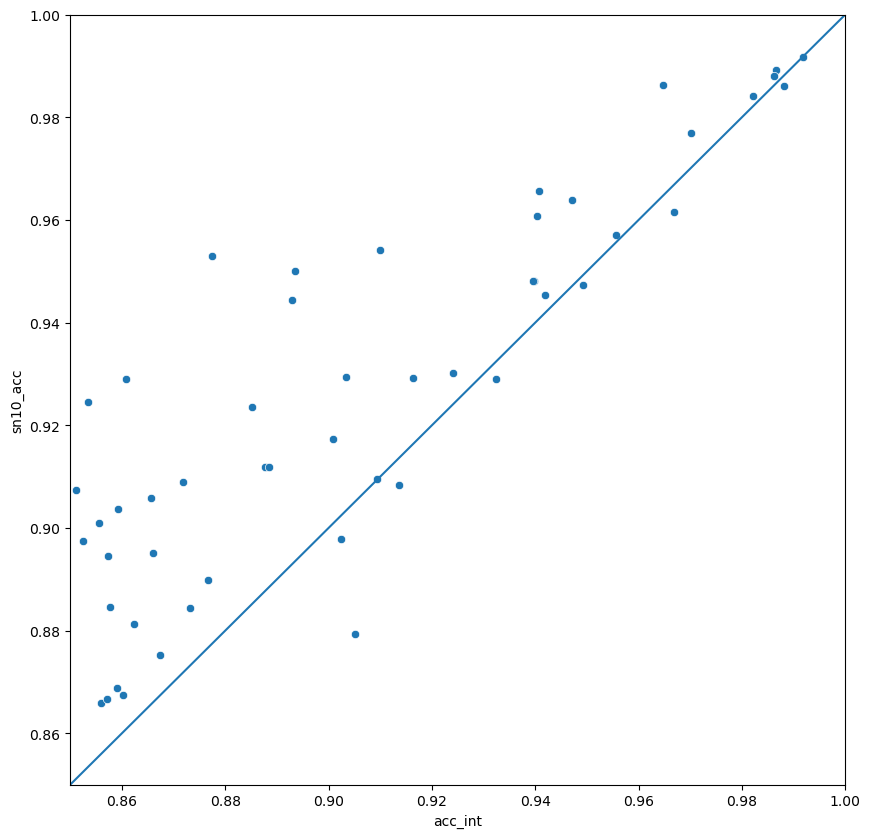

In [128]:
fig, ax = plt.subplots(figsize=(10, 10))
sns.scatterplot(data=df_motifs_sel, x="acc_int", y="sn10_acc")
ax.plot([0, 1], [0, 1], transform=ax.transAxes)
ax.set_xlim(0.85, 1)
ax.set_ylim(0.85, 1)

## Mine complex rules

In [ ]:
BEAM_B = 20
BEAM_N = 2

In [ ]:
df_train = df_train.reset_index(drop=True)

for i, row in df_train.iterrows():
    ag = row["Antigen"]
    slide = row["Slide"]
    pass

In [ ]:
for i in range():
    # new_motifs = get_new_motifs()
    # beam_search_motifs += new_motifs

    # if makes_sense:
    #     evaluate new motifs
    #     get top from generated new motifs